Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

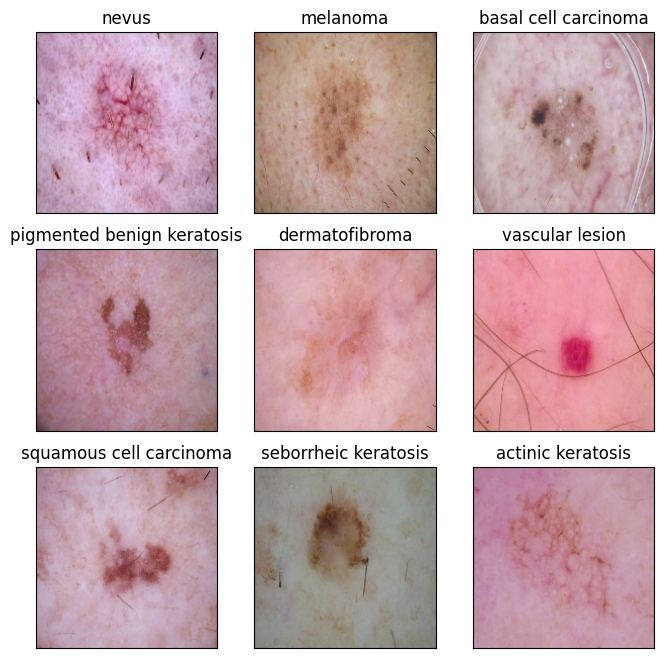

In [9]:
import matplotlib.pyplot as plt

class_images = {}

# Iterate through dataset and collect 1 image per class
for images, labels in train_ds:
    for img, label in zip(images, labels.numpy()):
        class_name = class_names[label]
        if class_name not in class_images:  # Store only the first occurrence
            class_images[class_name] = img
        if len(class_images) == num_classes:  # Stop when we have all classes
            break
    if len(class_images) == num_classes:
        break

# Plot images
fig = plt.figure(figsize=(8, 8))
for i, (class_name, img) in enumerate(class_images.items()):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.set_title(class_name)
    ax.imshow(img.numpy().astype("uint8"))  # Convert Tensor to NumPy for plotting

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2015 - loss: 2.0793

KeyboardInterrupt: 

### Visualizing training results

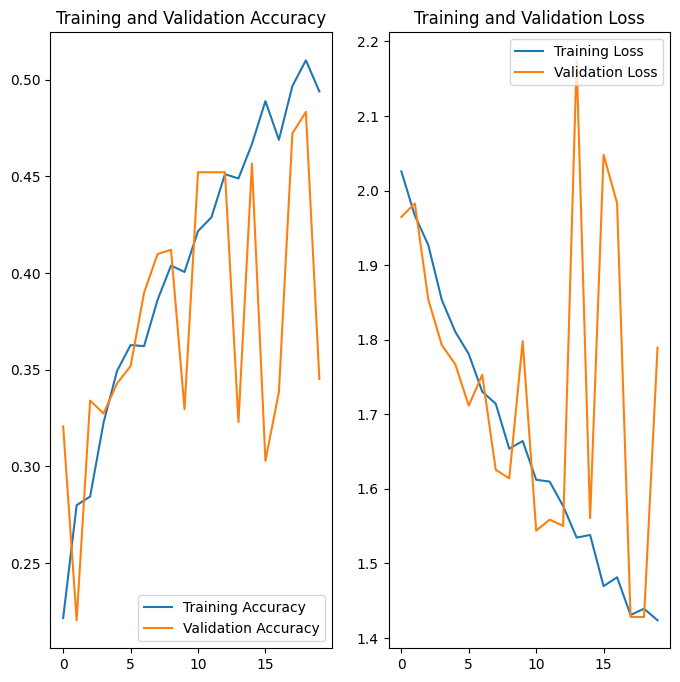

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model is underfitting, Hence adding few more convolutional layer with increased number of filters

In [ ]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')])

In [ ]:
model.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1813 - loss: 2.1393 - val_accuracy: 0.1915 - val_loss: 2.0348
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1965 - loss: 2.0327 - val_accuracy: 0.1915 - val_loss: 2.0323
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2061 - loss: 2.0360 - val_accuracy: 0.1960 - val_loss: 2.0281
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2110 - loss: 2.0229 - val_accuracy: 0.1960 - val_loss: 2.0278
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2293 - loss: 1.9908 - val_accuracy: 0.2071 - val_loss: 2.0264
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2413 - loss: 1.9991 - val_accuracy: 0.2339 - val_loss: 2.0062
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2788 - loss: 1.9953 - val_accuracy: 0.2584 - val_loss: 1.9733
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2789 - loss: 1.9666 - val_accuracy: 0.3118 - v

### Still model is underfitting, Hence using Data augmentaion strategy

In [15]:
#  Using data augumentation strategy.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.3),
])

for images, labels in train_ds.take(1):
    img = images[0]  # Select the first image
    break

# Expand dimensions to match batch shape
img_expanded = tf.expand_dims(img, axis=0)

# Apply augmentation
augmented_img = data_augmentation(img_expanded)

# Convert back to numpy array for plotting
augmented_img = augmented_img.numpy().squeeze()
img = img.numpy()

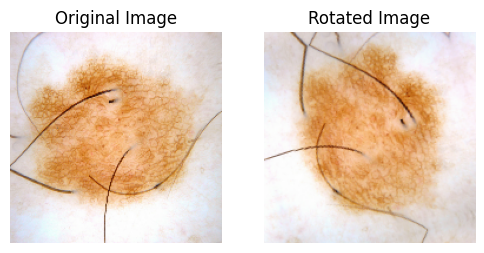

In [16]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(6,3))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Augmented (Rotated) image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img.astype("uint8"))
plt.title("Rotated Image")
plt.axis("off")

plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
model = tf.keras.Sequential([
  layers.RandomRotation(0.3, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')])


### Compiling the model

In [ ]:
model.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_16 (RandomRotation)  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_11 (RandomFlip)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_20 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1995 - loss: 2.1006 - val_accuracy: 0.1915 - val_loss: 2.0262
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2186 - loss: 2.0117 - val_accuracy: 0.2183 - val_loss: 1.9813
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2505 - loss: 1.9885 - val_accuracy: 0.3163 - val_loss: 1.9460
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2806 - loss: 1.9682 - val_accuracy: 0.2895 - val_loss: 1.8916
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2985 - loss: 1.9260 - val_accuracy: 0.2428 - val_loss: 2.0348
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3036 - loss: 1.8860 - val_accuracy: 0.3408 - val_loss: 1.7853
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3190 - loss: 1.8430 - val_accuracy: 0.3430 - val_loss: 1.7864
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3486 - loss: 1.7969 - val_accuracy: 0.3363 - v

### Visualizing the results

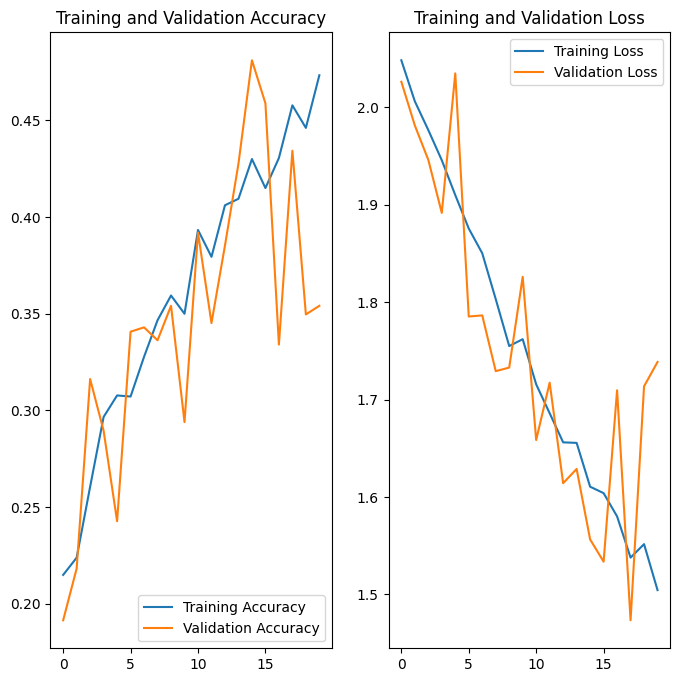

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from collections import Counter
class_counts = Counter()

# Iterate through the dataset to count occurrences of each class
for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Print the class distribution
for class_idx, count in sorted(class_counts.items()):
    print(f"{class_names[class_idx]}: {count} samples")

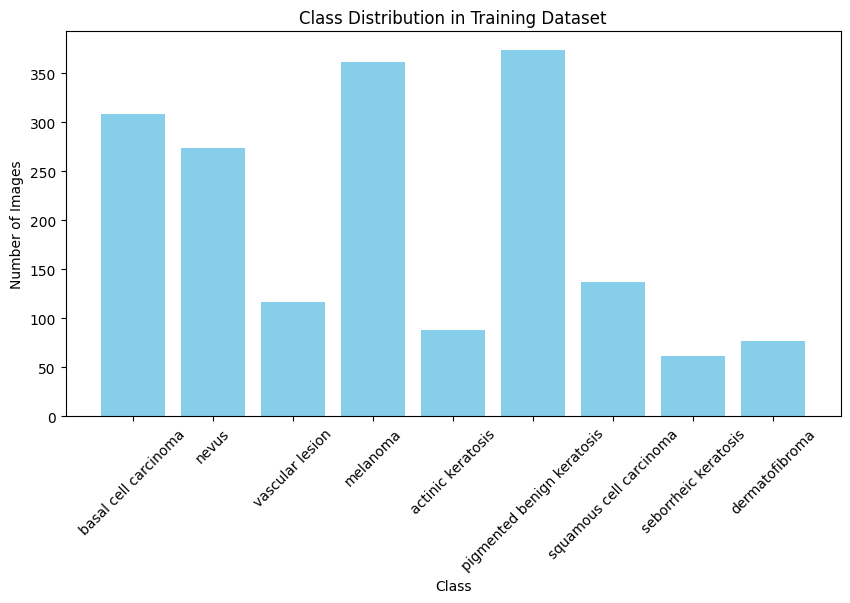

In [18]:
class_labels = [class_names[i] for i in class_counts.keys()]
counts = list(class_counts.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Seborrheic keratosis has the least number of samples
#### - Pigmented benign keratosis dominate the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [19]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset='/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6C20371710>: 100%|██████████| 500/500 [00:16<00:00, 30.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6C281640D0>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6C201759D0>: 100%|██████████| 500/500 [00:17<00:00, 28.71 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A6BB07D3590>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7A6BB07D2B50>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6C20175390>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A6BB0768810>: 100%|██████████| 500/500 [00:37<00:00, 13.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A6BB074D7D0>: 100%|██████████| 500/500 [00:17<00:00, 28.87 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6C2CBD59D0>: 100%|██████████| 500/500 [00:17<00:00, 29.09 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [10]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [11]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/melanoma_original_ISIC_0000412.jpg_aac49cc6-978b-4c89-bd45-a166456630bb.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/melanoma_original_ISIC_0000309.jpg_9a0c9660-f986-4eba-8d28-1e3dca5c843f.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_6e2078f5-4507-4905-8568-b37f1032c694.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/melanoma_original_ISIC_0010789.jpg_06fc532d-d39b-41c1-97d5-89ecda2c1db7.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/melanoma_original_ISIC_0000513.jpg_134b5a94-36fa-4086-95d3-133b13eae94b.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/output/mela

In [12]:
# Older Path
path_list = glob(os.path.join(data_dir_train, '*', '*.jpg'))
path_list

['/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000141.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000145.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000148.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000146.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000139.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000150.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000149.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/ISIC_0000147.jpg',
 '/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train/melanoma/IS

In [13]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [14]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [15]:
dataframe_dict_old = dict(zip(path_list, lesion_list_new))

In [16]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [18]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [19]:
new_df['Label'].value_counts()

,count
Label,
melanoma,1000
squamous cell carcinoma,1000
basal cell carcinoma,1000
pigmented benign keratosis,1000
seborrheic keratosis,749
actinic keratosis,500
vascular lesion,500
nevus,500
dermatofibroma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [20]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [25]:
data_dir_train= "/content/gdrive/My Drive/AIML/Melanoma_Detection_Assignment/Melanoma_Dataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size=batch_size)


Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2)
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

#### **Todo:**  Train your model

In [ ]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Yes, the model's performance has improved after addressing class imbalance, as increasing the amount of training data has enhanced its accuracy and effectiveness.